📦 Instance : A-n32-k5
🚛 Camions utilisés : 6
📏 Coût total        : 1019.45
⏱️  Makespan (dernier camion) : 259.41
✅ Contraintes respectées : capacité + temps (attente autorisée)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35648\2013795193.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes))


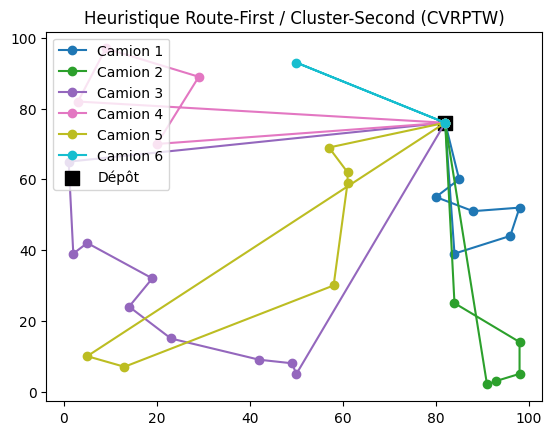

: 

In [ ]:
# ============================================================
# 🧩 LIVRABLE 2 – Heuristique Route-First / Cluster-Second
#      CVRPTW : capacités + fenêtres temporelles réalistes
# ============================================================

import math
import matplotlib.pyplot as plt
import vrplib
import os
import numpy as np


# ============================================================
# 1️⃣ CHARGEMENT D’UNE INSTANCE VRPLIB
# ============================================================
def load_vrplib_instance(name="A-n32-k5"):
    """
    Lit une instance VRPLIB locale et prépare toutes les données nécessaires :
      - coordonnées des clients
      - demandes
      - capacité max Q
      - fenêtres temporelles réalistes
      - temps de service fixe
    """

    filename = f"{name}.vrp"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"❌ Le fichier {filename} est introuvable !")

    # Lecture VRPLIB (format dict)
    instance = vrplib.read_instance(filename)

    # Lecture des données avec compatibilité selon les versions VRPLIB
    nodes = instance.get("node_coord", instance.get("node_coords"))
    demands = instance.get("demand", instance.get("demands"))
    Q = instance["capacity"]
    depot = instance.get("depot", [1])[0]

    # Conversion éventuelle ndarray → dict
    if isinstance(nodes, np.ndarray):
        nodes = {i + 1: tuple(nodes[i]) for i in range(len(nodes))}
    if isinstance(demands, np.ndarray):
        demands = {i + 1: int(demands[i]) for i in range(len(demands))}

    # Vérification dépôt
    if depot not in nodes:
        depot = 1

    customers = [i for i in nodes.keys() if i != depot]

    # --- Fonction de distance euclidienne ---
    def dist(i, j):
        xi, yi = nodes[int(i)]
        xj, yj = nodes[int(j)]
        return math.hypot(xi - xj, yi - yj)

    # --- Génération de fenêtres temporelles réalistes ---
    time_windows = {}
    time_windows[depot] = (0, 1000)  # grande fenêtre pour le dépôt

    for i in customers:
        d_to_depot = dist(depot, i)
        # 💬 Fenêtre proportionnelle à la distance :
        # plus le client est loin, plus sa fenêtre est tardive et large
        earliest = d_to_depot * 0.5
        latest = d_to_depot * 2.5 + 100
        time_windows[i] = (earliest, latest)

    # --- Temps de service fixe pour tous les clients ---
    service_time = {i: 10 for i in nodes.keys()}  # 10 unités de temps / client

    return nodes, customers, depot, demands, Q, dist, time_windows, service_time


# ============================================================
# 2️⃣ CONSTRUCTION DE LA TOURNÉE GLOBALE (Route-First)
# ============================================================
def nearest_neighbor_route(customers, depot, dist):
    """
    Heuristique du plus proche voisin (Nearest Neighbor) :
    construit une grande tournée reliant tous les clients une fois.
    """
    route = [depot]
    remaining = set(customers)
    current = depot

    while remaining:
        nxt = min(remaining, key=lambda c: dist(current, c))
        route.append(nxt)
        remaining.remove(nxt)
        current = nxt

    route.append(depot)
    return route


# ============================================================
# 3️⃣ DÉCOUPAGE SELON CAPACITÉ ET TEMPS (Cluster-Second)
# ============================================================
def split_by_capacity_and_time(global_route, demands, Q, depot, dist, time_windows, service_time):
    """
    Découpe la tournée globale en plusieurs sous-tournées faisables
    en respectant :
      ✅ la capacité max du camion Q
      ✅ les fenêtres temporelles [a_i, b_i]
      ✅ les temps de service
    """
    routes = []
    current_route = [depot]
    current_load = 0
    current_time = 0

    for client in global_route[1:]:
        if client == depot:
            continue

        demand = demands[client]
        a_i, b_i = time_windows[client]

        # ⏱️ Temps de trajet depuis le dernier point
        travel_time = dist(current_route[-1], client)
        arrival_time = current_time + travel_time

        # 🕒 Si on arrive trop tôt, on attend jusqu’à a_i
        service_start = max(arrival_time, a_i)

        # ❌ Si on dépasse la fenêtre ou la capacité → on démarre un nouveau camion
        if service_start > b_i or current_load + demand > Q:
            # Retour au dépôt pour terminer la tournée actuelle
            current_route.append(depot)
            routes.append(current_route)

            # 🚛 Nouveau camion depuis le dépôt
            current_route = [depot, client]
            current_load = demand
            # Arrivée depuis le dépôt
            arrival_from_depot = dist(depot, client)
            current_time = max(arrival_from_depot, a_i) + service_time[client]
        else:
            # ✅ On ajoute le client à la tournée actuelle
            current_route.append(client)
            current_load += demand
            current_time = service_start + service_time[client]

    # Dernier retour au dépôt
    current_route.append(depot)
    routes.append(current_route)
    return routes


# ============================================================
# 4️⃣ ÉVALUATION DES TOURNÉES
# ============================================================
def route_cost(route, dist):
    """Coût total d’une route (somme des distances)."""
    return sum(dist(route[i], route[i + 1]) for i in range(len(route) - 1))

def total_cost(routes, dist):
    """Somme des coûts de toutes les tournées."""
    return sum(route_cost(r, dist) for r in routes)

def makespan(routes, dist):
    """Retour du dernier camion (distance max)."""
    return max(route_cost(r, dist) for r in routes)


# ============================================================
# 5️⃣ VISUALISATION
# ============================================================
def plot_solution(routes, coords, depot):
    """Affiche graphiquement les tournées construites."""
    colors = plt.cm.get_cmap('tab10', len(routes))
    for i, r in enumerate(routes):
        xs = [coords[n][0] for n in r]
        ys = [coords[n][1] for n in r]
        plt.plot(xs, ys, marker='o', color=colors(i), label=f"Camion {i+1}")
    plt.scatter(coords[depot][0], coords[depot][1],
                color='black', s=100, marker='s', label="Dépôt")
    plt.legend()
    plt.title("Heuristique Route-First / Cluster-Second (CVRPTW)")
    plt.show()


# ============================================================
# 6️⃣ PIPELINE COMPLET
# ============================================================
def route_first_cluster_second(name="A-n32-k5"):
    """
    Exécute toute la pipeline :
      1. Chargement de l’instance
      2. Construction d’une tournée globale
      3. Découpage en tournées faisables
      4. Évaluation et affichage
    """
    coords, customers, depot, demands, Q, dist, time_windows, service_time = load_vrplib_instance(name)

    # Étape 1 : TSP global
    global_route = nearest_neighbor_route(customers, depot, dist)

    # Étape 2 : Split capacité + fenêtres
    routes = split_by_capacity_and_time(global_route, demands, Q, depot, dist, time_windows, service_time)

    # Étape 3 : Évaluation
    cost = total_cost(routes, dist)
    mksp = makespan(routes, dist)

    print(f"📦 Instance : {name}")
    print(f"🚛 Camions utilisés : {len(routes)}")
    print(f"📏 Coût total        : {cost:.2f}")
    print(f"⏱️  Makespan (dernier camion) : {mksp:.2f}")
    print("✅ Contraintes respectées : capacité + temps (attente autorisée)")

    # Vérification de la faisabilité (visites et capacité)
    visited = [v for r in routes for v in r if v != depot]
    assert set(visited) == set(customers), "❌ Tous les clients ne sont pas visités !"
    for r in routes:
        load = sum(demands[v] for v in r if v != depot)
        assert load <= Q, f"❌ Capacité dépassée ({load} > {Q})"

    # Étape 4 : Affichage graphique
    plot_solution(routes, coords, depot)

    return routes, cost, mksp


# ============================================================
# 7️⃣ TEST RAPIDE
# ============================================================
if __name__ == "__main__":
    route_first_cluster_second("A-n32-k5")


les contrainte que j'ai pris on consideration sont : 
| Élément                               | Catégorie                   | Niveau atteint                 |
| ------------------------------------- | --------------------------- | ------------------------------ |
| Capacité                              | ✔️ respectée                | ✅                              |
| Fenêtres temporelles                  | Attente autorisée           | ✅ Version avancée              |
| Multi-véhicules                       | Oui (découpe automatique)   | ✅                              |
| Méthode                               | Heuristique déterministe    | ✅ Route-first / Cluster-second |
| Flotte hétérogène                     | Non (mais facile à ajouter) | 🔜 possible                    |
| Métaheuristique (tabou, génétique...) | ❌ non utilisée              | (pas nécessaire ici)           |

le fonctionment du code apres l'import de l'instance a-n32.... :

| Contrainte                  | Où elle est appliquée                              | Commentaire                                                              |
| :-------------------------- | :------------------------------------------------- | :----------------------------------------------------------------------- |
| **Visite unique**           | `nearest_neighbor_route()` + `assert set(visited)` | chaque client visité une fois                                            |
| **Capacité camion**         | `split_by_capacity_and_time()`                     | dès que somme des charges > Q → nouveau camion                           |
| **Fenêtres temporelles**    | `split_by_capacity_and_time()`                     | compare `arrival_time`, `a_i`, `b_i`, ajoute attente si arrivée trop tôt |
| **Attente autorisée**       | même fonction                                      | `waiting = a_i - arrival_time` appliqué quand on est en avance           |
| **Multi-camions**           | automatique (plusieurs routes créées)              | chaque route correspond à un camion                                      |
| **Dépôt unique**            | `depot` unique (identifié dans VRPLIB)             | tous les trajets partent et reviennent au même dépôt                     |
| **Objectif (min distance)** | `total_cost()`                                     | somme de toutes les distances                                            |
| **Makespan**                | `makespan()`                                       | distance max d’un camion, affichée                                       |
